In [16]:
import torch
import torchvision
from torch import nn
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import warnings

In [3]:
data_dir = "D:\\Documents\\CMU_SUBJECTS\\Deep Learning\\Generative_Modelling\\SimpleGAN\\data\\pokemon"
pokemon = torchvision.datasets.ImageFolder(data_dir)

Observing input distribution


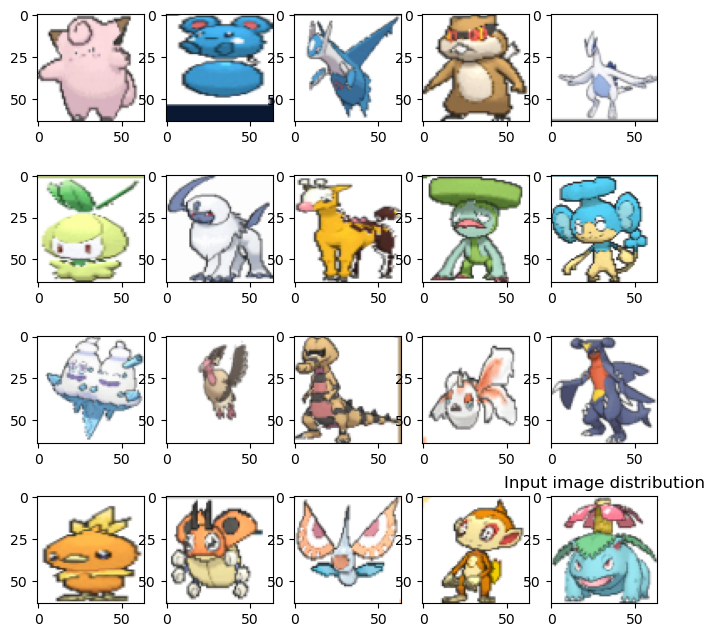

In [19]:
batch_size = 256
transformer = torchvision.transforms.Compose([torchvision.transforms.Resize((64,64)), torchvision.transforms.ToTensor(), torchvision.transforms.Normalize(0.5, 0.5)])
pokemon.transform = transformer

# Dataloader class 
train_loader = DataLoader(dataset = pokemon, shuffle= True, batch_size= batch_size)

# Some pokemons 
#plt.set_figsize((4,4))
for i, (X, y) in enumerate(train_loader):
    img = X[:20, ].permute(0,2,3,1)/2 + 0.5
    break

print("Observing input distribution") 
warnings.filterwarnings('ignore')

fig=plt.figure(figsize=(8, 8))
rows, cols = 4, 5

for j in range(0, cols*rows):
  fig.add_subplot(rows, cols, j+1)
  plt.imshow(img[j])
plt.title("Input image distribution")
plt.show()

